In [1]:
CONSUMER_KEY = "REPLACE WITH OWN KEY"
CONSUMER_SECRET = "REPLACE WITH OWN KEY"
ACCESS_TOKEN = "REPLACE WITH OWN KEY"
ACCESS_TOKEN_SECRET = "REPLACE WITH OWN KEY"

In [2]:
import socket
import sys
import requests
import requests_oauthlib
import json
import tweepy
from tweepy import Cursor
from tweepy import Stream
from tweepy.streaming import StreamListener
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
import time
import numpy as np

pd.set_option('display.width', 1000)
%matplotlib notebook

auth = tweepy.OAuthHandler(CONSUMER_KEY, CONSUMER_SECRET)
auth.set_access_token(ACCESS_TOKEN, ACCESS_TOKEN_SECRET)

## 1. Retrieve list of tweets with word 'python'

In [3]:
api = tweepy.API(auth, wait_on_rate_limit=True)

In [4]:
def tweet_to_df(search_results):
    dict_list = []
    for tweet in search_results:
        dict_list.append(tweet._json)

    with open('tweets.txt', 'w') as file:
            file.write(json.dumps(dict_list, indent=4))

    my_demo_list = []
    tweet_df = []
    with open('tweets.txt', encoding='utf-8') as json_file:  
        all_data = json.load(json_file)
        for d in all_data:
            tweet_id = d['id']

            # Retrieve full text of tweet, or retweet
            try:
                text = d['retweeted_status']['full_text']
            except KeyError:  # Not a Retweet
                text = d['full_text']

            retweet_count = d['retweet_count']
            created_at = d['created_at']
            my_demo_list.append({'tweet_id': str(tweet_id),
                                 'text': str(text),
                                 'retweet_count': int(retweet_count),
                                 'created_at': created_at,
                                })
            #print(my_demo_list)
            tweet_df = pd.DataFrame(my_demo_list, columns = 
                                      ['tweet_id', 
                                       'text', 
                                       'retweet_count', 
                                       'created_at'])
    return tweet_df

In [5]:
results = api.search(q="Python", lang="en", rpp=10, tweet_mode="extended")

tweet_df = tweet_to_df(results)
tweet_df = tweet_df.sort_values(by='retweet_count', ascending=False)
tweet_df.head()

,tweet_id,text,retweet_count,created_at
10,1364765558005248000,@CovariantAI @pabbeel @covariant @abigailhingw...,13,Thu Feb 25 02:33:59 +0000 2021
2,1364765775345709060,@chantalsimonato @sminaev2015 @FriseSally @ang...,11,Thu Feb 25 02:34:51 +0000 2021
7,1364765592964726784,We will be live streaming this week Mon-Fri \n...,11,Thu Feb 25 02:34:08 +0000 2021
0,1364765813518008323,Udemy Free Discount - React - Mastering Test D...,10,Thu Feb 25 02:35:00 +0000 2021
3,1364765731578085378,Udemy Free Discount - R Data Pre-Processing &a...,6,Thu Feb 25 02:34:41 +0000 2021


In [6]:
tweet_df['text']

10    @CovariantAI @pabbeel @covariant @abigailhingw...
2     @chantalsimonato @sminaev2015 @FriseSally @ang...
7     We will be live streaming this week Mon-Fri \n...
0     Udemy Free Discount - React - Mastering Test D...
3     Udemy Free Discount - R Data Pre-Processing &a...
4     Udemy Free Discount - R Data Pre-Processing &a...
5     Udemy Free Discount - R Data Pre-Processing &a...
6     Multi-Core Machine Learning in Python With Sci...
1     Coupons Free Discount - React, Angular, Node I...
8     @ibm I completed Python for Data Science, AI &...
9     If you've ever asked yourself " What the heck ...
11    @SeemaSaharan5 which\n\nWe’re messing with bui...
Name: text, dtype: object

## 2. Plot frequency distribution of hashtags of incoming stream of tweets

In [7]:
def parse_hashtags(hashtag_list):
    # Function parses the list of hashtags, and return all list of hashtags in lower case
    ht = []
    
    for tag in hashtag_list:
        ht.append(tag['text'].lower())

    return ht

In [8]:
# Retrieve incoming tweet stream and write 
class MyStreamListener(tweepy.StreamListener):
    def __init__(self, api):
        self.api = api
        self.me = api.me()

    def on_status(self, tweet):
        if tweet.truncated == True:
            hashtags = parse_hashtags(tweet.extended_tweet['entities']['hashtags'])
        else:
            hashtags = parse_hashtags(tweet.entities['hashtags'])

#         print('items in list = ', len(hashtags))
        with open('hashtags.txt', 'a') as f:
            for item in hashtags:
                f.write("%s\n" % item)
            
    def on_error(self, status):
        print("Error detected")
        
        
api = tweepy.API(auth, wait_on_rate_limit=True,
    wait_on_rate_limit_notify=True)

tweets_listener = MyStreamListener(api)
stream = tweepy.Stream(api.auth, tweets_listener)
stream.filter(track=["Python", "Django", "Tweepy"], languages=["en"], is_async=True)

<IPython.core.display.Javascript object>


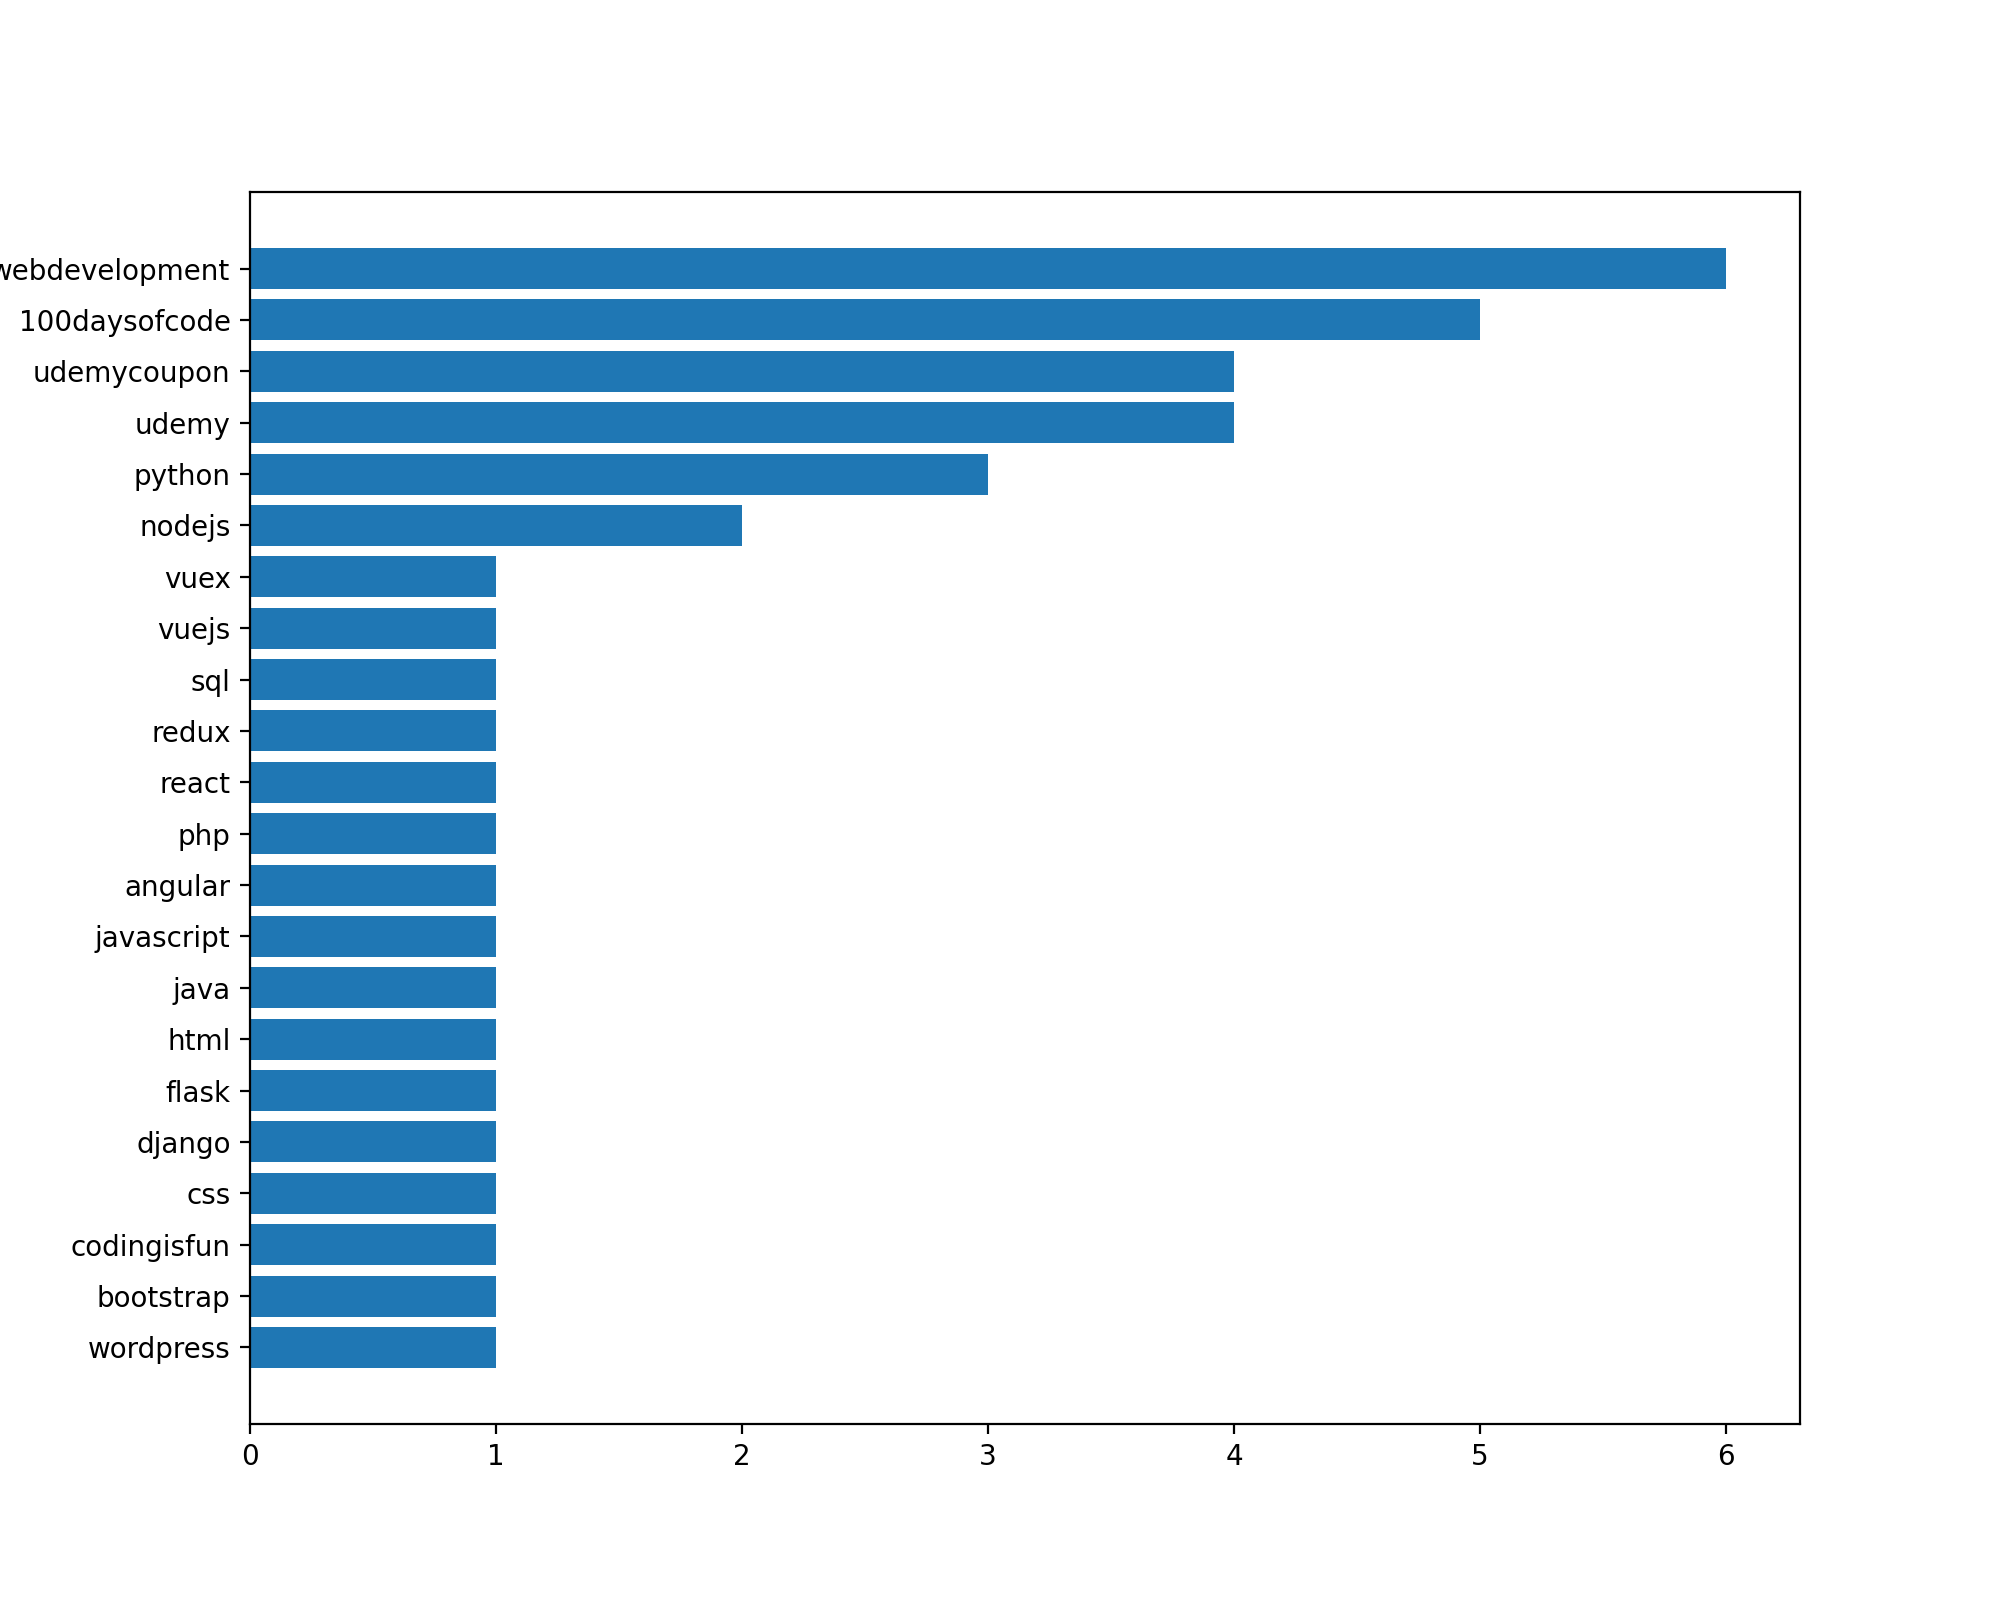

KeyboardInterrupt: 

In [10]:
def read_and_plot(ax):
    # Read text file of hashtags
    df = pd.read_csv('hashtags.txt', delimiter = "\n", names=['hashtag'])

    df_group = df[['hashtag']].groupby(['hashtag']).agg({'hashtag':['count']})
    df_group.columns = df_group.columns.to_flat_index()
    df_group.reset_index(inplace=True)
    df_group.columns = ['hashtag','count']

    # Sort by count and get top 50 tweets
    df_group.sort_values(by='count', ascending=False, inplace=True)
    df_group = df_group.head(50)
    
    y_labels = df_group['hashtag'].tolist()
    values = df_group['count'].tolist()
    
    # Clear previous axis before refresh
    ax.cla()
    plt.ion()
    plt.show()
    
    # Example data
    y_pos = np.arange(len(y_labels))
    
    ax.barh(y_pos, values, align='center')
    ax.set_yticks(y_pos)
    ax.set_yticklabels(y_labels)
    ax.invert_yaxis()  # labels read top-to-bottom
    plt.draw()
    plt.pause(0.001)
    fig.canvas.draw()

figsize = (10, 8)
fig, ax = plt.subplots(figsize=figsize)

# Plot and refresh every 3s
while True:
    read_and_plot(ax)
    time.sleep(3)

## 3. Sentiment analysis of tweets related to Bitcoin

In [12]:
search_terms = "#bitcoin-filter:retweets"

tweets = []
for tweet in tweepy.Cursor(api.search,
                           q=search_terms,
                           lang="en",
                           tweet_mode="extended",
                           since='2021-01-01').items(1000):
    tweets.append(tweet)
    
# tweets = Cursor(api.search,
#                    q=search_terms,
#                    lang="en",
#                    since='2021-01-01').items(1000)
tweet_df = tweet_to_df(tweets)

In [13]:
len(tweet_df)

1000

In [14]:
from textblob import TextBlob

# Retain only text column, and perform sentiment analysis
tweet_list = tweet_df['text'].tolist()

sentiment_objects = [TextBlob(tweet) for tweet in tweet_list]

sentiment_values = [[tweet.sentiment.polarity, str(tweet)] for tweet in sentiment_objects]

# sentiment_objects[1].polarity, sentiment_objects[0]
sentiment_df = pd.DataFrame(sentiment_values, columns=["polarity", "tweet"])

sentiment_df.head()

,polarity,tweet
0,0.000000,"📉💴$2,024,000 #bitcoin SHORTED @$50618.0 [25/02..."
1,0.000000,"📉💴$2,000,000 #bitcoin SHORTED @$50624.03 [25/0..."
2,0.307143,@chamath Does that include selling your #bitco...
3,0.000000,"📉💴$2,000,000 #bitcoin SHORTED @$50646.98 [25/0..."
4,0.000000,Banning #bitcoin is like banning electricity o...


In [15]:
len(sentiment_df)

1000

<IPython.core.display.Javascript object>


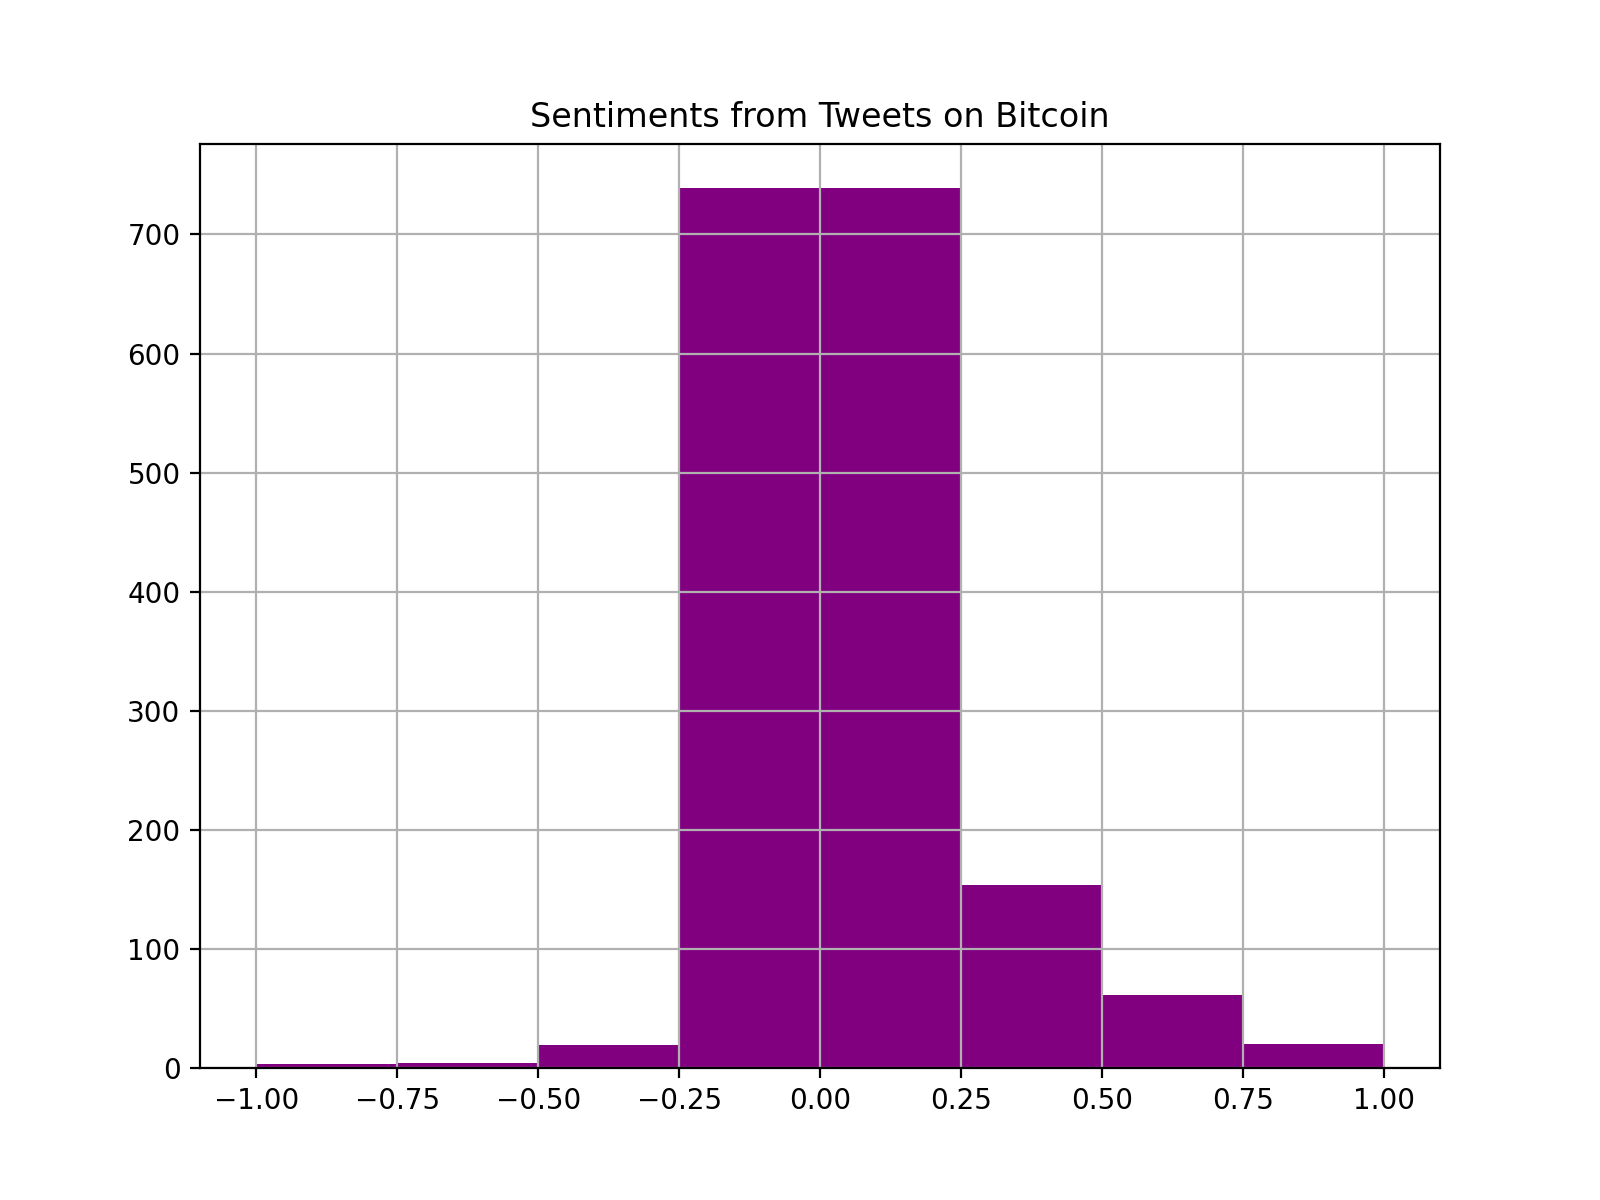

In [16]:
fig, ax = plt.subplots(figsize=(8, 6))

# Plot histogram of the polarity values
sentiment_df.hist(bins=[-1, -0.75, -0.5, -0.25, 0.25, 0.5, 0.75, 1],
             ax=ax,
             color="purple")

plt.title("Sentiments from Tweets on Bitcoin")
plt.show()